In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import trange
from math import e
from scipy.stats import beta
from scipy.spatial import distance

In [2]:
#Important variables

E = 5 #number of effector genes, IMPORTANT VARIABLE
default_nodes = np.linspace(0,E,E+1)
default_nodes = [int(i) for i in default_nodes] #maternal factor and E effector genes, can't be duplicated or removed
effectors = np.delete(default_nodes, 0) #effector genes don't have outgoing edges, only incoming

In [3]:
default_nodes

[0, 1, 2, 3, 4, 5]

In [4]:
effectors

array([1, 2, 3, 4, 5])

In [5]:
#arbitrary mutation rates
#we could also make these rates evolve themselves
dn_rate = 0.005
dup_rate = 0.005
del_rate = 0.01
edge_rate = 0.8

In [6]:
#Make perfect gene expression states for each environment
nenvs = 2 #number of environments that fluctuate, IMPORTANT VARIABLE
envs = [] #for keeping track of the environment
def generate_optimum(nenvs, neffect):
    if nenvs == 2:
        x = np.linspace(0,1,100)
        a, b = 2, 7
        y = beta.pdf(x, a, b)
        y /= y.max()
        e=[]
        for i in range(neffect):
            t = y[int((100/neffect)*i)]
            t = np.around(t,2)
            e.append(t)
        envs.append(np.asarray(e))
        envs.append(np.asarray(e[::-1]))
    else:
        for env in range(nenvs):
            x = np.linspace(0,1,100)
            a, b = np.random.randint(low=1,high=30,size=1), np.random.randint(low=2,high=30,size=1)
            y = beta.pdf(x, a, b)
            y /= y.max()
            e=[]
            for i in range(neffect):
                t = y[int((100/neffect)*i)]
                t = np.around(t,2)
                e.append(t)                                
            envs.append(np.asarray(e))

In [7]:
generate_optimum(2,E)

In [8]:
envs

[array([0.  , 0.92, 0.32, 0.04, 0.  ]), array([0.  , 0.04, 0.32, 0.92, 0.  ])]

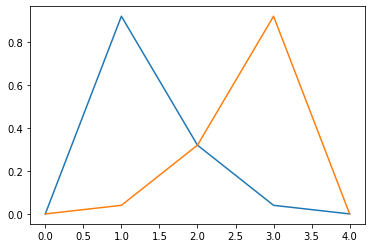

In [9]:
for env in range(len(envs)):
    plt.plot(envs[env])
plt.show()

In [21]:
#Agents have special attributes and the following functions:
#4 different kinds of mutations, a sigmoid function for "binding affinity", a grn output function (!) and a fitness function

class Agent:
    def __init__(self, E):
        """
        Initialization of an individual.
        Parameters:
            :int N:         Number of nodes in the GRN.
        Returns:
            None. Constructor method.
        """
        
        #BUILDING INITIAL GRN
        N = E+1
        self.N = N #number of initial nodes, maternal + effectors
        self.nodes = list(np.arange(N))
        self.adjM = np.zeros((N, N))
        self.adjM[0,1:] = 0.1 
        #initiate with maternal connected to effector genes 
        self.adjM[0,0] = 1
        #and maternal positive feedbackloop (otherwise it turns itself down immediately and so the rest is also repressed)
        
        #OTHER PARAMETERS
        self.alpha = 10 #for sigmoid function - could be mutated later, now constant
        self.blacklist = [] #set of deleted genes
        self.fitness = 0
    
    def mutate(self, dn_rate = dn_rate, dup_rate = dup_rate, del_rate = del_rate, edge_rate = edge_rate):
        
        if random.uniform(0, 1) < dn_rate:
            self.add_dn_node()
            
        if random.uniform(0, 1) < dup_rate:
            self.add_dup_node()
            
        if random.uniform(0, 1) < del_rate:
            self.del_node()
            
        if random.uniform(0, 1) < edge_rate:
            self.mut_edge()
    
    def add_dn_node(self): 
        #de novo gene, no interactions when initiated
        self.nodes.append(self.N)

        #Make adj matrix bigger
        column_to_be_added = np.zeros(self.N)
        self.adjM = np.column_stack((self.adjM, column_to_be_added)) 
        self.N += 1
        
        if self.N > 50:
            print("Number of nodes greater than 50!")
        
        row_to_be_added = np.zeros(self.N)
        self.adjM = np.vstack((self.adjM, row_to_be_added))
        
    def add_dup_node(self):
        #duplicate a node with all of its connections
        avail = list(set(self.nodes) - set(self.blacklist) - set(default_nodes))
        
        if len(avail) > 0:
            dup_node = np.random.choice(avail)

            column_to_be_added = self.adjM[:,dup_node] #duplicate column
            self.adjM = np.column_stack((self.adjM, column_to_be_added)) 

            row_to_be_added = self.adjM[dup_node,:] #duplicate row
            self.adjM = np.vstack((self.adjM, row_to_be_added))

            self.nodes.append(self.N)
            self.N += 1
            
            if self.N > 50:
                print("Number of nodes greater than 50!")
        
    def del_node(self):
        #delete an existing node with is not an effector or maternal gene
        #rows/columns in adj matrix are not deleted, all interactions are set to 0 instead
        #self.N incudes deleted nodes!
        avail = list(set(self.nodes) - set(self.blacklist) - set(default_nodes))
        
        if len(avail) > 0:
        
            deleted_node = np.random.choice(avail)

            self.adjM[deleted_node,:] = np.zeros(self.N)
            self.adjM[:,deleted_node] = np.zeros(self.N)

            self.blacklist.append(deleted_node)
        
    def mut_edge(self):
        #mutate the weight of an edge
        avail = list(set(self.nodes) - set(self.blacklist))
        
        mod_avail_from = list(set(avail) - set(effectors)) #effectors can't regulate
        from_nodes = np.random.choice(mod_avail_from)
        
        avail.remove(0) #maternal can't be regulated
        
        if from_nodes != 0: #otherwise I would remove 0 twice
            avail.remove(from_nodes) #self loops are not allowed
        
        to_nodes = np.random.choice(avail)
        
        self.adjM[from_nodes,to_nodes] = np.around(np.random.normal(0, 1, 1), 2)
        
    
    def sigm(self,sum_input):
    #adapted from wang 2014
        sum_input = sum_input-0.5
        x = sum_input * -self.alpha
        output = 1/(1 + np.exp(x))
        return output
    
    def grn_output(self, debug=False):
    #explained further later    
        a = self.adjM
        if debug:
            print(a)

        #thresh = np.vectorize(lambda x : -1 if x < 0 else (1 if x > 0 else 0)) #sign function for regulatory genes
        step = lambda a,s: self.sigm(s.dot(a)) #a step is matrix multiplication followed by checking on sigmodial function
        s = np.zeros(self.N)
        s[0] = 1 #starts with only maternal factor on
        e=0 #counter for state stability
        i=0 #counter for number of GRN updates
        ss=[] #stores GRN state for comparision to updated state
  
        while e < 2 and i < 3*(self.N-len(self.blacklist)):
            if debug:
                print(s) #print expression state
            ss.append(s) #only maternal ON at first
            s=step(a,s)
            s=np.around(s,2)
            s[s <=0.01] =0 #otherwise as sigm(0) is 0.01 deleted nodes wouldn't really be deleted
            s[s ==0.99] =1 #otherwise maternat impact is not constant but reducing
            if np.array_equal(ss[i], s):
                if i != 0:
                    e+=1
            i+=1

        if e > 1:
            conc_of_effectors = s[1:E+1]

        else:
            conc_of_effectors = np.linspace(0,0,E)
            conc_of_effectors = [int(i) for i in conc_of_effectors]
        return(conc_of_effectors)
    
def fitness_function(grn_out, state):
    #distance of GRN output to perfect expression in specific environmental state
    if np.sum(grn_out) != 0:
        grn_out = np.asarray(grn_out)

        diff = np.abs(grn_out - envs[state]).sum()
        f = 1-diff/E
    else:
        #print('not stable')
        f = 0

    return(f**3)

In [11]:
a = Agent(5)

In [12]:
print(a.N)
print(a.nodes)
print(a.adjM)

6
[0, 1, 2, 3, 4, 5]
[[1.  0.1 0.1 0.1 0.1 0.1]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]


In [13]:
a.add_dn_node()
print(a.adjM)

[[1.  0.1 0.1 0.1 0.1 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]]


In [14]:
for i in range(100):
    a.mut_edge() 
print(a.adjM)

[[ 1.    0.67  0.08 -0.27 -0.11 -0.27 -2.67]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -1.49 -0.53  0.7  -0.47  0.02  0.  ]]


In [15]:
conc_of_effectors = a.grn_output(debug=True)

[[ 1.    0.67  0.08 -0.27 -0.11 -0.27 -2.67]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -1.49 -0.53  0.7  -0.47  0.02  0.  ]]
[1. 0. 0. 0. 0. 0. 0.]
[1.   0.85 0.   0.   0.   0.   0.  ]
[1.   0.85 0.   0.   0.   0.   0.  ]


[0.   0.04 0.32 0.92 0.  ]
1
[0.85 0.   0.   0.   0.  ]
1
[1.   0.96 0.68 0.08 1.  ]
1


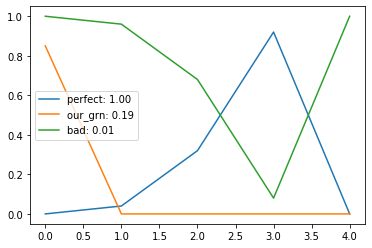

In [16]:
perf_fitness = fitness_function(envs[1],1)
plt.plot(envs[1],label=f"perfect: {perf_fitness:.2f}")

#now if we compare this to the pattern we get above
our_fitness = fitness_function(conc_of_effectors,1)
plt.plot(conc_of_effectors, label=f'our_grn: {our_fitness:.2f}')

#which is much lower than for the perfect but still higher than for
bad_fitness = fitness_function((1-envs[1]),1)
plt.plot(1-envs[1], label=f"bad: {bad_fitness:.2f}")
plt.legend()
plt.show()

In [17]:
def create_pop(pop_size,E):
    pop = []
    
    for i in range(pop_size):
        t = Agent(E)
        pop.append(t)
        
    return(pop)  

In [22]:
def evolve(pop_size, gens, season_length, E):
    #gens = number of generations
    #season_length = number of generations before environment switches
    pop = create_pop(pop_size, E)
    state = 0 # we start with environment 0
    
    
    for i in trange(gens):
        #every generation
        #check fitness and generate new population
        
        
        for idx, ind in enumerate(pop): #mutate 
            ind.mutate()
                                
        for p in pop:
            grn_out = p.grn_output()
            p.fitness = fitness_function(grn_out,state) #will depend on env
                 
        pop_fitness = [x.fitness for x in pop]  
        tot_fitness = np.sum(pop_fitness)
        average_fitness.append(np.mean(pop_fitness))
        

        pop_prob = [f/tot_fitness for f in pop_fitness]
        new_pop = np.random.choice(pop, pop_size, p=pop_prob, replace = True) #same individual can be selected over and over again
        pop = [deepcopy(agent) for agent in new_pop]
        
        rd = (i+1) % season_length
        
        if rd == 0:
            #print("after this changed state")
            if state == 0:
                state = 1 #np.random.choice(nenvs)
            else:
                state = 0
                
    
    best_agent = max([{"fitness" : x.fitness, "Agent" : x} for x in pop], key=lambda x : x["fitness"])["Agent"]
    print(best_agent.adjM)
    print(best_agent.fitness)
    print(best_agent.grn_output())
    
    return(pop)

In [29]:
average_fitness = []

In [30]:
population = evolve(pop_size = 1000, gens = 100, season_length = 1000, E=5)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]

[[ 1.   -0.03  0.73  0.44  0.18 -0.41 -1.16  0.    0.   -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -2.    0.82 -0.81 -0.15  2.01  0.   -0.4  -0.29  1.22]
 [ 0.   -1.41 -0.34  1.89 -0.25  0.22  0.    0.    1.15 -0.26]
 [ 0.    0.   -1.23 -0.76 -0.59  2.05  0.48  0.07  0.    2.51]
 [ 0.   -0.57  0.73  0.5   0.    1.5  -1.21  0.    0.    0.  ]]
0.976191488
[0.   0.91 0.35 0.04 0.  ]


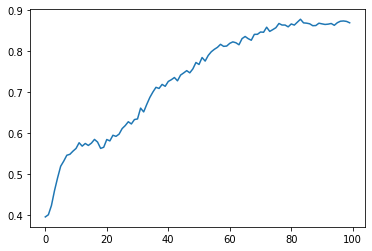

In [31]:
plt.plot(average_fitness)

In [1]:
pop=[1,2,3,4,5]

In [18]:
np.average(pop)

3.0

In [17]:
for i in range(100):
    sample = np.random.choice(pop, 4, replace=False)
    print(sample)
    if sample[0]==sample[1]:
        print("SAME")

[2 1 4 5]
[2 1 4 3]
[2 5 3 4]
[5 2 4 3]
[2 1 3 5]
[5 4 2 3]
[3 5 4 2]
[5 1 2 3]
[3 2 1 5]
[4 2 5 3]
[5 4 2 1]
[2 4 3 1]
[2 5 1 3]
[1 5 4 3]
[5 4 3 1]
[4 2 3 5]
[2 3 4 5]
[1 4 3 2]
[1 2 3 5]
[4 3 1 2]
[2 5 4 1]
[1 4 2 3]
[3 1 4 5]
[3 4 2 1]
[1 5 4 2]
[3 5 4 1]
[1 4 3 5]
[2 5 1 4]
[1 3 2 5]
[1 5 3 4]
[3 4 5 2]
[1 4 3 5]
[4 5 3 1]
[2 3 5 1]
[2 1 3 4]
[5 3 1 4]
[3 4 1 5]
[5 3 4 1]
[3 1 2 4]
[4 5 2 3]
[4 1 2 3]
[4 5 2 3]
[4 2 3 5]
[3 2 1 4]
[2 1 3 5]
[3 1 2 5]
[5 3 4 2]
[4 3 5 1]
[3 4 1 2]
[3 1 5 2]
[1 5 4 3]
[1 3 4 5]
[3 4 2 5]
[3 2 4 5]
[5 4 2 3]
[2 3 1 4]
[1 5 3 4]
[2 4 1 5]
[3 2 5 4]
[5 3 4 2]
[3 1 2 4]
[2 4 1 5]
[3 2 5 1]
[5 3 2 4]
[4 5 2 1]
[1 5 2 4]
[2 4 3 5]
[5 2 1 3]
[5 4 1 2]
[4 1 3 5]
[3 1 5 4]
[2 5 4 3]
[3 2 4 5]
[2 5 1 4]
[2 5 4 1]
[2 1 4 3]
[1 3 5 2]
[4 5 2 1]
[5 1 2 4]
[3 5 2 4]
[2 4 1 5]
[5 1 4 2]
[1 4 2 3]
[2 3 1 5]
[4 3 5 1]
[4 5 3 2]
[4 5 2 3]
[4 5 2 1]
[1 3 4 2]
[1 2 4 5]
[5 1 2 4]
[3 2 5 4]
[3 4 2 5]
[5 4 1 3]
[4 3 1 2]
[5 4 1 2]
[3 1 2 5]
[4 5 1 2]
[5 2 1 4]
[2 3 5 4]


In [11]:
sample

array([2, 4])